## Предсказание уровней воды на реке Амур

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import shap

from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV

In [2]:
# Путь до папки с данными
path_to_data = 'datasets/'

Определяем период, на который будем предсказывать (в нашем случае это первые 10 дней ноября)

In [3]:
predict_period = ['2019-11-01', '2019-11-11'] 
f_day = datetime.strptime(predict_period[0], '%Y-%m-%d') 
l_day = datetime.strptime(predict_period[1], '%Y-%m-%d')
predict_ndays = (l_day - f_day).days

 Загрузка данных об уровнях воды на гидропостах.
 
 Датасет `daily.pkl` - собран из всех файлов `{номер_станции}_daily.csv` из папки 'datasets/', 
 номер гидропоста записан в отдельной колонке. Колонки приведены к соответствующим форматам, датасет отсортирован по (номеру гидропоста, дате)

In [4]:
daily = pd.read_pickle(path_to_data + 'processed_data/daily.pkl')

In [5]:
daily = daily.sort_values(by=['station_id','date'])
daily = daily.reset_index(drop=True)

In [6]:
# Выбираем целевые гидрологические посты
station_ids = [6005, 6022, 6027, 5004, 5012, 5024, 5805]
daily = daily[daily['station_id'].isin(station_ids)]

Посмотрим как выглядит ряд для фиксированного `station_id`

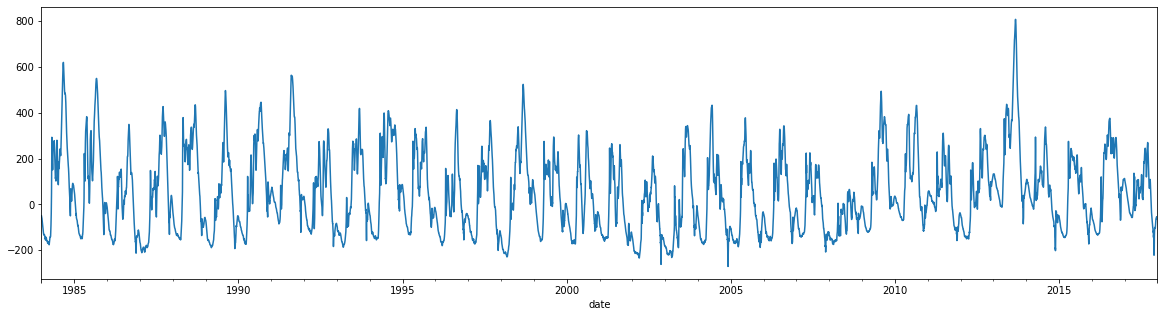

In [7]:
daily = daily.set_index('date')
daily.loc[daily['station_id'] == 5012, 'stage_max'].plot(figsize=(20, 5))
daily = daily.reset_index()

Загрузим и приведем к соответствующим форматам свежие данные по целевым вышкам, которые находятся в файле `datasets/hydro2019-20/new_data.csv`

In [8]:
nf = pd.read_csv(path_to_data + 'hydro_2018-2020/new_data_target.csv', sep=';')

In [9]:
nf['time'] = pd.to_datetime(nf['time'], format='%Y-%m-%d %H:%M:%S')
nf.columns = ['date', 'stage_max', 'station_id']
nf = nf.sort_values(by=['station_id', 'date'])
nf = nf.set_index('date')
nf = nf[nf.index > '2017-12-31']

Посмотри на графики новых данных:

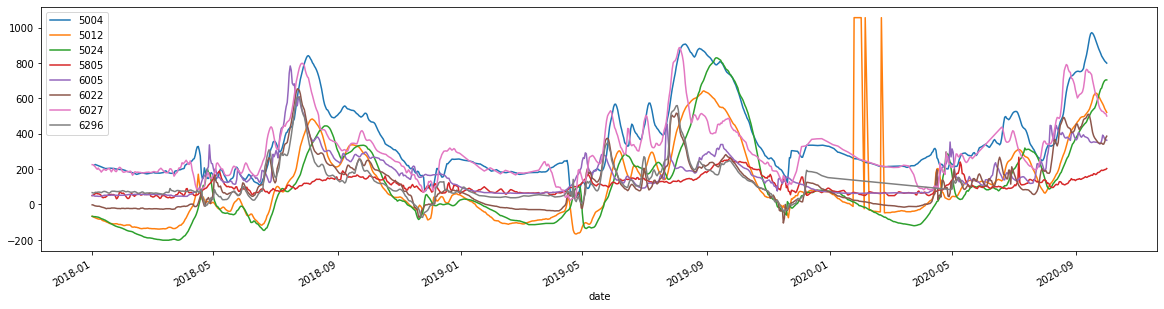

In [10]:
plt.figure(figsize=(20,5))
leg = []
for st in nf.station_id.unique():
    sf = nf[nf['station_id'] == st]
    sf['stage_max'].plot()
    leg.append(st)
plt.legend(leg)

Удалим выбросы у гидрологичского поста с номером 5012

In [11]:
nf.loc[(nf['stage_max'] > nf['stage_max'].\
          quantile(0.99))&(nf['station_id'] == 5012), 'stage_max'] = np.nan

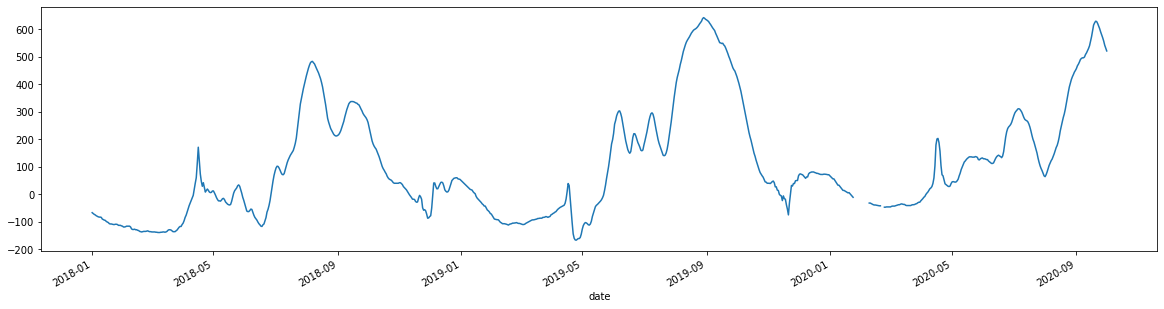

In [12]:
sf = nf[nf['station_id'] == 5012]
sf['stage_max'].plot(figsize=(20,5))

Приведем индексы к такому же виду как в daily и соеденим датасеты 

In [13]:
nf = nf.reset_index()
nf = nf.reindex(['date', 'stage_avg', 'stage_min', 'stage_max', 'temp', 'water_code',
       'station_id'], axis=1)
daily = pd.concat([daily, nf], axis=0)
daily = daily.sort_values(by=['station_id', 'date'])

### Метеоданные 
Загрузка метеоданных, соответстующих целевым гидрологическим постам. 

Используемый датасет `s2m.pkl` - (station_to_meteo) - это таблица в которой номеру гидрологического поста поставлен в соответсвие номер ближайшей метеостанции, а так же указано расстояние до неё. Координаты гидрологических постов и метеостанций взяты из http://asunp.meteo.ru/geoits-rest/services/asunp/geo.json

In [14]:
s2m = pd.read_pickle(path_to_data + 'processed_data/s2m.pkl')
s2m.head()

,meteo_id,dist
station_id,,
5674,4943321,81.846330
5216,4433241,21.467114
6256,5172691,62.347672
5132,4483421,27.216443
5151,4393311,1.111949


Пример таблицы с метеоданными

In [15]:
pd.read_csv(path_to_data + 'meteo/4263131.csv', sep=';').head()

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,...,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
0,GAMOV,4263131,NaN,6,254.0,0,5.0,0,NaN,7.0,...,NaN,NaN,5,NaN,6,1.2,0,76.0,0,2013-04-17 21:00:00
1,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 18:00:00
2,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 15:00:00
3,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,...,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 12:00:00
4,GAMOV,4263131,NaN,6,233.0,0,7.0,0,NaN,10.0,...,NaN,NaN,5,NaN,6,3.4,0,75.0,0,2013-04-17 09:00:00


In [16]:
# Вспомогательная функция для соединения идентичных датафреймов 
def weary_append(x,y):
    if x is not None:
        if any([a for a in list(x.columns) if a not in y.columns]) or any([a for a in list(y.columns) if a not in x.columns]):
            raise ValueError()
        else:
            return x.append(y)
    else:
        return y

Считываем файлы с метеоданными, соответствующие целевым гидрологическим постам. Номер метеостанции записываем в колонку `meteo_id`, а номер гидрологического поста в `station_id`

In [17]:
meteo = None
for s, m in s2m.loc[station_ids][['meteo_id']].iterrows():
    m = m.values[0]
    df = pd.read_csv(path_to_data + 'meteo/{}.csv'.format(m), sep=';').rename({'station_id': 
                                                                                        'meteo_id'}, axis=1)
    df['datetime'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
    df['date'] = df['datetime'].apply(lambda x: x.date())
    df['station_id'] = s
    meteo = weary_append(meteo, df)

Согласно описанию данных (а именно файл Время_85.docx) данные до '1993-1-1' записывались по GMT +3, поэтому переведем их к Гринвичу

In [18]:
meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'] = \
    meteo.loc[meteo['date'] < datetime(1993,1,1).date(), 'datetime'].apply(lambda x: x - timedelta(hours=3))

Усреднение температурных признаков по (времени суток, дате)

In [19]:
meteo = meteo.set_index('datetime')
meteo[meteo.index.month==3].groupby(meteo[meteo.index.month==3].index.hour)['temperature_air'].mean()

datetime
0    -10.401762
3     -5.039252
6     -2.809799
9     -3.957306
12    -7.727059
15   -10.338852
18   -12.013950
21   -13.245664
Name: temperature_air, dtype: float64

In [20]:
meteo['night'] = (meteo.index.hour > 14) | (meteo.index.hour < 2)
dmeteo = meteo.groupby(['station_id', 'date', 'night'])[['temperature_air', 
                                                    'temperature_ground']].mean().reset_index(level=2)
dmeteo = dmeteo.pivot(columns='night')
ncols = []
for col in dmeteo.columns:
    if col[1]:
        prefix = 'night_'
    else:
        prefix = 'day_'
    ncols.append(prefix + col[0])
dmeteo.columns = ncols

Получили датасет со средней ночной и дневной температурой воздуха и почвы за каждый день.

In [21]:
dmeteo.head()

day_temperature_air  night_temperature_air  \
station_id date                                                     
5004       1985-01-01              -17.900                -24.400   
           1985-01-02              -16.775                -26.250   
           1985-01-03              -18.975                -24.650   
           1985-01-04              -19.150                -26.050   
           1985-01-05              -21.200                -27.675   

                       day_temperature_ground  night_temperature_ground  
station_id date                                                          
5004       1985-01-01                 -19.950                   -27.275  
           1985-01-02                 -19.725                   -29.375  
           1985-01-03                 -19.900                   -26.900  
           1985-01-04                 -19.900                   -28.175  
           1985-01-05                 -21.775                   -28.175

Значения влажности воздуха беру среднее за сутки, а кол-во осадков - максимальное

In [22]:
dmeteo[['humidity', 'precipitation_amount']] = \
meteo.groupby(['station_id', 'date'])[['humidity', 'precipitation_amount']].agg({'humidity': 'mean', 
                                                                                 'precipitation_amount': 'max'})

Реализуем функцию, которая будет аггрегировать метео признаки по заданному количеству дней, заданной функцией и сдвигать на заданное число дней

In [23]:
def agg_meteo(df, 
              columns = ['day_temperature_air', 'night_temperature_air', 'day_temperature_ground', 
                         'night_temperature_ground', 'humidity','precipitation_amount'],
              agg_days = [15, 15, 15, 15, 10, 60],
              agg_funcs = ['mean', 'mean', 'mean', 'mean', 'sum', 'sum'],
              shift = [10, 10, 10, 10, 10, 10]):
    res = pd.DataFrame(index=df.index)
    names = []
    for c, d, f, s in zip(columns, agg_days, agg_funcs, shift):
        name = '{}_{}_{}'.format(c, d, s)
        res[name] = df[c].rolling(d, min_periods=1).agg(f).shift(s)
        names.append('{}_{}_{}'.format(c, d, s))
    return res.reset_index(), names

In [24]:
agg, meteo_feats = agg_meteo(dmeteo)
agg['date'] = pd.to_datetime(agg['date'])

Присоединяем метеоданные к посуточным замерам уровней

In [25]:
daily = daily.merge(agg, on=['station_id', 'date'], how='left')

In [26]:
daily.shape

(93596, 13)

Создаем "календарные" признаки

In [27]:
daily = daily.set_index('date')
daily['year'] = daily.index.year
daily['month'] = daily.index.month
daily['day'] = daily.index.day
daily['doy'] = daily.index.dayofyear
daily = daily.reset_index()

По графикам можно наблюдать некую годовую сезонность в значениях уровня воды. Поэтому, могут оказаться полезными признаки: значения уровня воды последние годы в предсказываемые даты.

In [28]:
# Вспомогательная функция, прибавляющая года в кол-ву years к дате d
def add_years(d, years):
    try:
        return d.replace(year = d.year + years)
    except ValueError:
        return d + (datetime(d.year + years, 1, 1) - datetime(d.year, 1, 1))

In [29]:
# Цикл по количеству рассматриваемых лет
past = []
for y in range(1, 6):
    daily['ndate'] = daily['date'].apply(lambda x: add_years(x, y))
    hf = daily[['ndate', 'station_id', 'stage_max']].rename({'ndate': 'date', 'stage_max': 
                                                             'past_{}'.format(y)}, axis=1)
    
#     Удаление дубликатов, появляющихся из-за 29 февраля
    hf = hf.set_index(['station_id', 'date']) 
    hf = hf[~hf.index.duplicated(keep='first')]
    hf = hf.reset_index()
    
    daily = daily.merge(hf, on=['station_id', 'date'], how='left').drop('ndate', axis=1)
#     Цикл по датам целевого периода
    for i in range(predict_ndays+1):
        daily['past_{}_{}'.format(y, i)] = daily['past_{}'.format(y)].shift(-i)
        past.append('past_{}_{}'.format(y, i))
    daily.drop('past_{}'.format(y), axis=1, inplace=True)

Осталось добавить признаки временного ряда, то есть значения таргета за ndays предыдущих дней. Но, так как в исходных датасетах встречаются пропущенные даты, их надо сначала заполнить NaN'ми. Для этого воспользуемся методом .date_range и .reindex

In [30]:
daily = daily.set_index(['station_id', 'date'])
new_index = pd.MultiIndex.from_product([daily.index.get_level_values(0).unique(), 
                                        pd.date_range('1984-1-1', '2020-10-01')])
daily = daily.reindex(new_index)

Создание признаков временного ряда

In [31]:
ndays = 20

In [32]:
daily['target'] = daily['stage_max']
ts = []
for i in range(ndays, 0, -1):
    daily['ts_{}'.format(i)] = daily.groupby('station_id')['stage_max'].shift(i)
    ts.append('ts_{}'.format(i))
# daily.drop('stage_max', axis=1, inplace=True)

Выкидываем строки в которых таргет NaN

In [33]:
daily = daily[daily['target'].notna()]

## Обучение

Для кросс-валидации использум деление выборки на __train__: до *f_day* i-го года; __test__: _predict_period_ i-го года, где i пробегает 5 последних лет, имеющихся в тренировочной выборке.

In [34]:
# Генератор индексов для кросс-валидации
def train_test_fold(df, f_day, l_day):
    for year in [f_day.year - 5 + i for i in range(5)]:
        f = '{}-{}'.format(year, datetime.strftime(f_day, '%m-%d'))
        l = '{}-{}'.format(year, datetime.strftime(l_day, '%m-%d'))
        yield df.index[df.index < f], df.index[(df.index>=f)&(df.index<l)]

Реализация функции пошагового предсказания.
На вход подается:
- `model` - обученная модель
- `ts_data` - значения таргета за последние _ndays_ тренировочной выборки
- `test_data` - дополнительные признаки, в тестовый период (признаки не должны зависеть от значений, которые могут быть получены только в тестовый период. Поэтому, например, все погодные признаки сдвинуты на _predict_ndays_ вперед)
- `features` - список названий доп. признаков
- `n` - количество дней, на которые строится предказание

In [35]:
def steps_predict(model, ts_data, test_data, features, n):
    isfeat = len(features) > 0
    test_features = test_data[features].values
    if isfeat:
        data = np.r_[test_features[0], ts_data].reshape(1,-1)
    else:
        data = ts_data.reshape(1,-1)
    predict = []
    predict.append(model.predict(data)[0])

    for i in range(1, n):
        ts_data = np.r_[ts_data[1:], predict[i-1]]
        if isfeat:
            data = np.r_[test_features[i], ts_data].reshape(1,-1)
        else:
            data = ts_data.reshape(1,-1)
        predict.append(model.predict(data)[0])
    return np.array(predict)

In [42]:
def metrics(true, pred, station_id, printit=False):
    mae = np.mean(np.abs(pred - true))   
    if printit:
        print("MAE: {}".format(mae))
    return mae

In [43]:
def plot_predict(true, pred, station_id=None):
    plt.figure(figsize=(20, 5))
    plt.plot(true)
    plt.plot(pred)
    leg = ['true values', 'predict values']
    
    plt.legend(leg)
    if station_id is not None:
        plt.title(station_id)
    plt.show()

Реализация собственной функции кросс-валидации модели. Разбиения строятся с помощью 
*train_test_fold(df, f_day, l_day)*. Ошибка на валидационной выборку считается метрикой $MAE$

In [54]:
def cross_val(model, dataset, gen, target_name, features, lag, predict_ndays, 
              station_id, ts, eval_metric='wmae2', plotit=False):
    mae_list = []
    rmse_list = []
    wmae_list = []
    wmae2_list = []
    for i in range(5):
        train_idx, test_idx = next(gen)
        X_train = dataset.loc[train_idx].sort_index()
        X_test = dataset.loc[test_idx].sort_index()

        X = X_train[features + ts].copy()
        y = X_train[target_name]
        
        if eval_metric == 'wmae2':
            eval_metr = lambda x, y: ['wmae2', comp_wmae2(x, y, station_id), True]
        else:
            eval_metr = eval_metric
        model.fit(X, y)
        
        ts_data = X_train[target_name].values[-lag:]
        predict = steps_predict(model, ts_data, X_test, features, predict_ndays)
        if target_name == 'delta':
            predict = X_test['mean_by_date'].values + predict
        true = X_test[target_name].values
        mae = metrics(true, predict,station_id)
        mae_list.append(mae)

        if plotit:
            plot_predict(true, predict, station_id=station_id)
    res_table = pd.DataFrame([mae_list, rmse_list, wmae2_list], 
                        index=['MAE', 'RMSE', 'WMAE2'],
                        columns = ['fold{}'.format(i) for i in range(1, 6)])
    return res_table

Посмотрим на степень влияние дополнительных признаков на результат модели. Для этого воспользуемся библиотекой `shap` https://shap.readthedocs.io/en/latest/index.html 

Обучение LGBM с дефолтными параметрами и всеми доп. признакими.

In [45]:
all_features = meteo_feats + ['year', 'month', 'doy'] + past
station_id = 5012
features = all_features

sf = daily.loc[station_id]
model_lgb = lgb.LGBMRegressor(random_state=33)
X_train = sf.loc[sf.index < f_day, features]
y_train = sf.loc[sf.index < f_day, 'target']
X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
model_lgb.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=33, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [46]:
X_importance = X_train
explainer = shap.TreeExplainer(model_lgb)
shap_values = explainer.shap_values(X_importance)

In [47]:
X_train

,day_temperature_air_15_10,night_temperature_air_15_10,day_temperature_ground_15_10,night_temperature_ground_15_10,humidity_10_10,precipitation_amount_60_10,year,month,doy,past_1_0,...,past_5_1,past_5_2,past_5_3,past_5_4,past_5_5,past_5_6,past_5_7,past_5_8,past_5_9,past_5_10
1984-01-01,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-02,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-03,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-04,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1984-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1984.0,1.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-27,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,300.0,40.0,...,-63.0,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0
2019-10-28,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,301.0,40.0,...,-67.0,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0
2019-10-29,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,302.0,40.0,...,-69.0,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0
2019-10-30,NaN,NaN,NaN,NaN,NaN,NaN,2019.0,10.0,303.0,40.0,...,-69.0,-70.0,-73.0,-73.0,-77.0,-89.0,-94.0,-98.0,-94.0,-93.0


Построения графика важности дополнительных признаков.

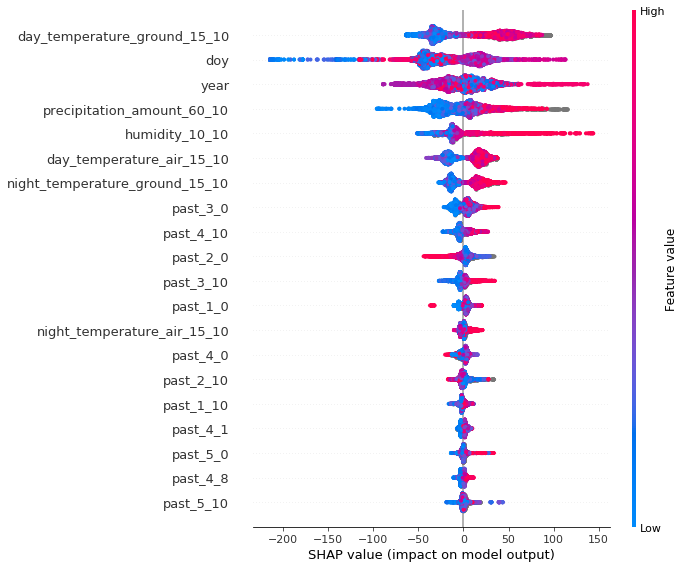

In [48]:
shap.summary_plot(shap_values, X_importance)

Из графика видно, что метеопризнаки довольно сильно влияют на целевое значение. Например, 
как и ожидалось, признак `precipitation_amount_60_10` - накопленные осадки за 60 дней, 10 дней назад при больших значениях дает положительный вклад в целевое значение, а при малых - отрицательный. Тот же эффект виден для `humidity_10_10` - накопленная влажность воздуха за 10 дней, 10 дней назад.

In [49]:
predict = model_lgb.predict(X_test)
true = y_test.values
metrics(true, predict, station_id)

32.75925779577402

###  GridSearch для поиска параметров модели

Простая функция для поиска трех основных параметров модели обучения:

In [50]:
def grid_search(df, params, features, ndays, predict_ndays, station_id, ts):
    best_metric = 500
    for ne in params['n_estimators']:
        for lr in params['learning_rate']:
            for nl in params['num_leaves']:
                model_lgb = lgb.LGBMRegressor(n_estimators=ne,
                                              learning_rate=lr,
                                              num_leaves=nl,
                                              random_state=33)
                gen = train_test_fold(sf, f_day, l_day)
                res = cross_val(model_lgb, df, gen, 'target', features, ndays, 
                                predict_ndays, station_id, ts, 'wmae2', plotit=False)
                metric = res.mean(axis=1)['MAE']
                if metric < best_metric:
                    best_metric = metric
                    best_params = dict(zip(params.keys(), [ne, lr, nl]))
    return best_params

In [51]:
grid_params = {
    'n_estimators': [30, 70, 110],
    'learning_rate': [0.05, 0.1, 0.12],
    'num_leaves': [27, 31, 37]
}

In [55]:
model_params = {}
for station_id in station_ids:
    sf = daily.loc[station_id].copy()
    features = all_features
    model_params[station_id] = grid_search(sf, grid_params, features, ndays, predict_ndays, station_id, ts)

### Результаты
В следующей ячейки собирается таблица с результатами предсказаний `sample_submission`, для последующей отправки. 

Построены графики с предсказанными и настоящими значениями и выведено значение метрики для каждого гидрологического поста.

6005  MAE:  9.294121061105663


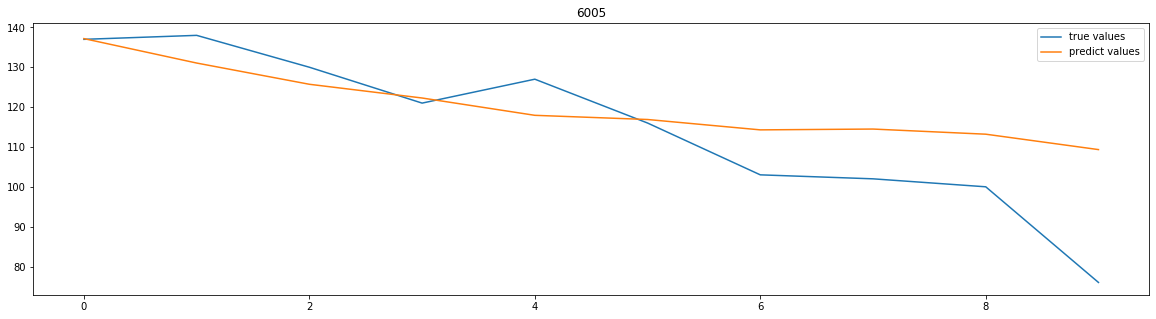

6022  MAE:  10.762157403047734


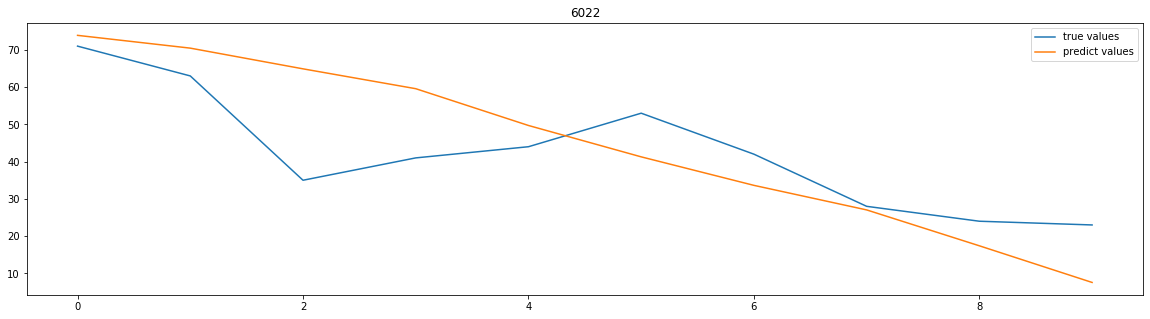

6027  MAE:  17.37000850318993


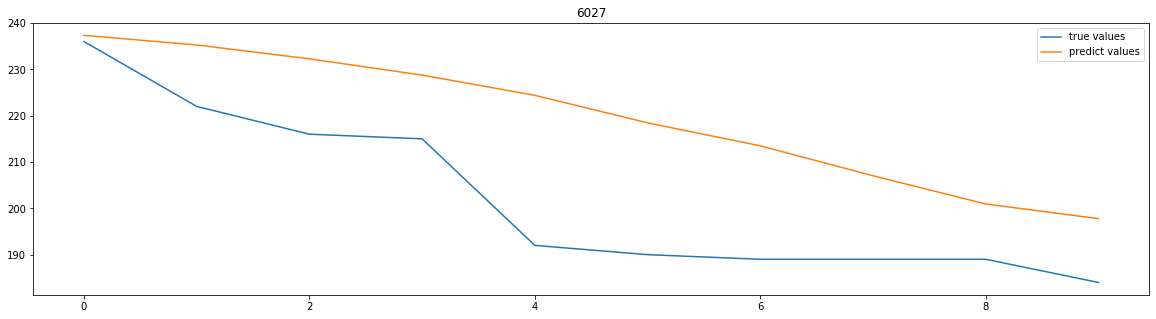

5004  MAE:  23.245771608120506


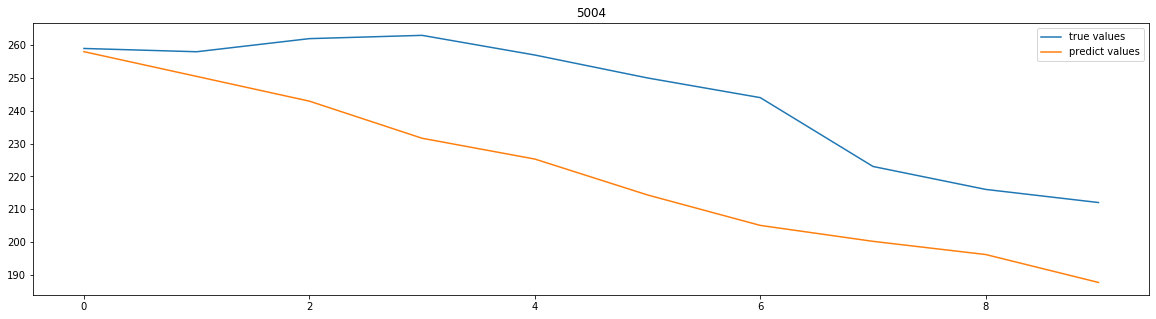

5012  MAE:  28.334837838429642


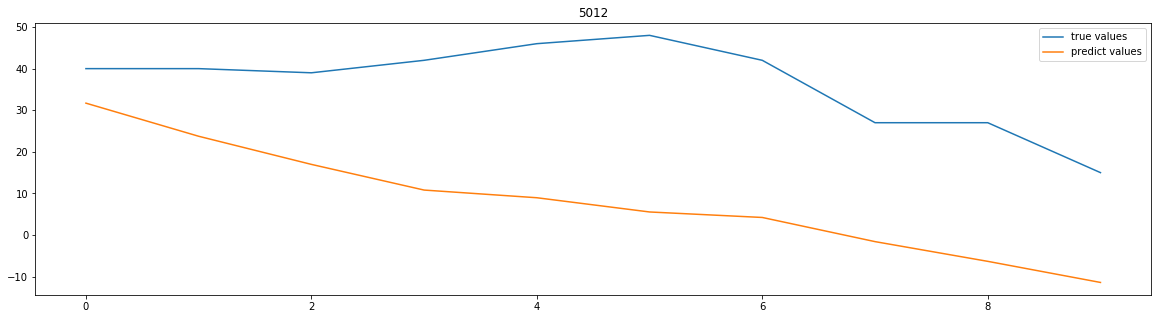

5024  MAE:  27.873136097752866


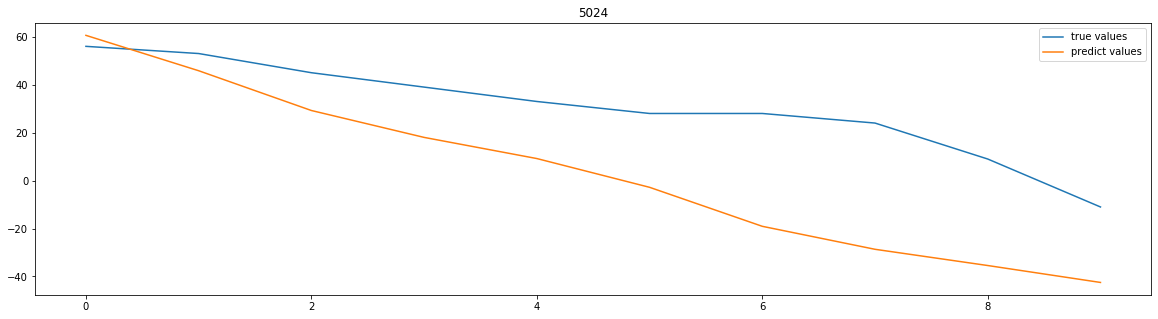

5805  MAE:  17.30985694165212


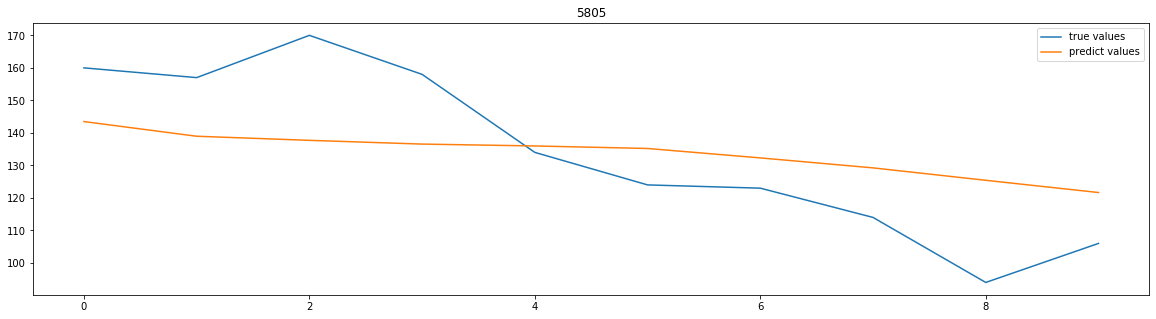

In [57]:
sample_submission = pd.DataFrame(index=pd.date_range(f_day, l_day - timedelta(1)))
lgbm_metrics = {}
for key in model_params:
    station_id = int(key)
    params = model_params[key]
    model_lgb = lgb.LGBMRegressor(n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],
                              num_leaves=params['num_leaves'],
                              random_state=33)
    sf = daily.loc[int(key)]
    X_train = sf.loc[sf.index < f_day, features + ts]
    y_train = sf.loc[sf.index < f_day, 'target']
    X_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), features]
    y_test = sf.loc[(sf.index >= f_day)&(sf.index < l_day), 'target']
    model_lgb.fit(X_train, y_train)
    ts_data = y_train.values[-ndays:]
    predict = steps_predict(model_lgb, ts_data, X_test, features, predict_ndays)
    sample_submission[key] = predict # запись результата в таблицу
    mae = metrics(y_test.values, predict, station_id)
    lgbm_metrics[station_id] = [mae]
    print(station_id, ' MAE: ', mae)
    plot_predict(y_test.values, predict, station_id)

#### Формат файла с результатом

In [58]:
sample_submission

,6005,6022,6027,5004,5012,5024,5805
2019-11-01,137.180847,73.893699,237.335707,258.026344,31.702432,60.584309,143.482483
2019-11-02,131.052637,70.462655,235.262273,250.476695,23.743919,45.830590,138.970330
2019-11-03,125.724605,64.905716,232.271498,242.930538,16.981014,29.237060,137.706250
2019-11-04,122.279553,59.576472,228.756903,231.607687,10.808647,18.019441,136.556078
2019-11-05,117.935110,49.700498,224.390524,225.262621,8.963131,9.195799,135.982544
2019-11-06,116.885918,41.280337,218.448764,214.306641,5.542228,-2.798273,135.205623
2019-11-07,114.283529,33.629421,213.493173,205.020523,4.221850,-19.067208,132.309224
2019-11-08,114.489074,27.037855,207.029381,200.156657,-1.585288,-28.655171,129.239393
2019-11-09,113.199359,17.402628,200.935507,196.134647,-6.326629,-35.426402,125.418551
2019-11-10,109.335281,7.567224,197.776354,187.619932,-11.399683,-42.482888,121.658376


Сохранение результатов

In [59]:
sample_submission.to_csv('sample_submission.csv')